## Is it possible to predict star ratings on Yelp?

This project focuses on whether business attributes like availabilty of parking, table service or reservations can be used to predict the star rating of a business on the Yelp website.

The data comes from the Yelp Open Data Set which contains 150,346 businesses with over 1.2 million attributes: https://www.yelp.com/dataset.

After cleaning the data and some basic EDA I will apply different machine learning models to find the right estimator.

Loosely sed on bootcamp project

Ordinal logistic regression

<br/>
<br/>
<br/>

### Data Cleaning

In [850]:
import pandas as pd
import json
import re
import numpy as np

In [851]:
# Several objects in the JSON file are wronlgy stored as python string objects and can't be normalized properly unless we remove the quotation marks first.
# I will only fix the 'Business Parking' values, because we will need them for the further analysis.

data = []

with open('yelp_dataset/yelp_academic_dataset_business.json') as f:
    for line in f:
        json_dict = json.loads(line)
        if json_dict['attributes']:
            if 'BusinessParking' in json_dict['attributes'].keys():
                json_dict['attributes']['BusinessParking'] = eval(json_dict['attributes']['BusinessParking'])
        data.append(json_dict)

In [852]:
businesses = pd.json_normalize(data)

In [853]:
# Make column names lowercase and seperate words with underscore

businesses.columns = businesses.columns.str.split(('.')).str[-1]

columns = []

for column in businesses.columns:
    column = re.sub(r'(\w)([A-Z])', r'\1_\2', column)
    column = re.sub(r'Restaurants_', r'', column)
    column = re.sub(r'Business_', r'', column)
    column = re.sub(r'(Range)([0-9])', r'\1', column)
    columns.append(column.lower())

businesses.columns = columns

In [854]:
# Several attribute columns contain a lot of missing values. We will get rid of them and also drop some other columns which are not interesting for us.

businesses[businesses.columns[13:]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 52 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   by_appointment_only    42339 non-null   object 
 1   accepts_credit_cards   119765 non-null  object 
 2   monday                 114474 non-null  object 
 3   tuesday                120631 non-null  object 
 4   wednesday              123771 non-null  object 
 5   thursday               125198 non-null  object 
 6   friday                 124999 non-null  object 
 7   saturday               110770 non-null  object 
 8   bike_parking           72638 non-null   object 
 9   price_range            85314 non-null   object 
 10  coat_check             5584 non-null    object 
 11  take_out               59857 non-null   object 
 12  delivery               56282 non-null   object 
 13  caters                 40127 non-null   object 
 14  wi_fi                  56914 non-nul

In [855]:
businesses.drop(
  [
    'attributes',
    'hair_specializes_in',
    'counter_service',
    'open24_hours',
    'dietary_restrictions',
    'accepts_insurance',
    'ages_allowed',
    'b_yo_bcorkage',
    'corkage',
    'smoking',
    'b_yo_b',
    'good_for_dancing',
    'coat_check',
    'by_appointment_only',
    'best_nights',
    'music',
    'drive_thru',
    'accepts_bitcoin',
    'dogs_allowed',
    'happy_hour',
    'wheelchair_accessible',
    'good_for_meal',
    'ambience',
    'business_parking',
    'address',
    'postal_code',
    'hours',
    'latitude',
    'longitude'
  ],
  axis=1, errors='ignore', inplace=True)

In [856]:
# Remove u'...' prefix from values

businesses[['alcohol', 'noise_level', 'attire', 'wi_fi']] = businesses[['alcohol', 'noise_level', 'attire', 'wi_fi']].apply(lambda x: x.str.strip("u'"), axis=0)

In [857]:
# Parking availability has different categories which are stored in separate columns.
# I want to create a new column that summarizes the categories and shows in general whether parking is available or not.

def check_parking(row):
    if True in row.values:
        return 'True'
    elif False in row.values:
        return 'False'
    else:
        return np.nan
    
businesses['parking'] = businesses[['garage', 'street', 'validated', 'lot', 'valet']].apply(check_parking, axis=1)

businesses.drop(['garage', 'street','validated','lot','valet'], axis=1, inplace=True)

<br>

### What are the top 20 business categories used by businesses in the data set?

The data set contains many different business types. Let's have a look which are the most common ones.

In [858]:
from collections import Counter

businesses_categories = []

for labels in businesses['categories'].str.split(', '):
    if labels is not None:
        for label in labels:
            businesses_categories.append(label)

top_20 = Counter(businesses_categories).most_common(20)

In [859]:
import matplotlib.pyplot as plt

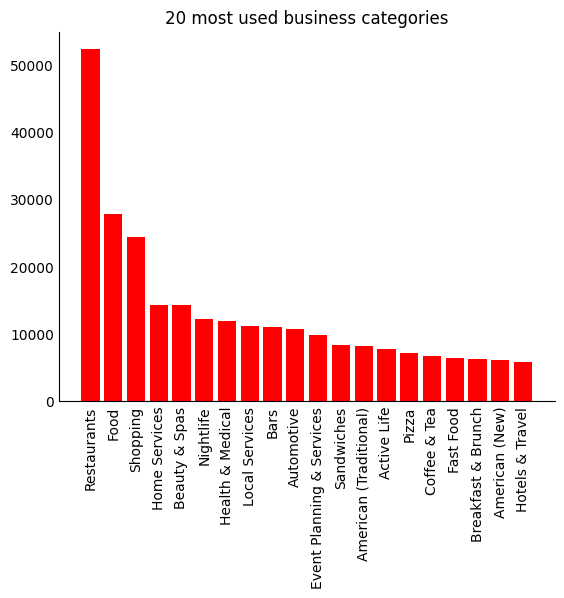

In [860]:
x = [i[0] for i in top_20]
y = [i[1] for i in top_20]

plt.bar(x, y, color='r')
plt.title('20 most used business categories')
plt.xticks(rotation=90)
plt.gca().spines[['right', 'top']].set_visible(False)
plt.tick_params(axis='both', length=0.0)
plt.show();

To make use of any prediction models, it would be sensible to focus on a single homogenous category with a reasonable amount of samples.

Let's go with 'Restaurants' since it clearly is the biggest category in the dataset!
<br/>
<br/>
<br/>

In [862]:
def get_restaurants(row):
    if row is None:
        return False
    if 'Restaurants' in row:
        return True
    
restaurants = businesses[businesses['categories'].apply(get_restaurants) == True].copy()

In [674]:
restaurants.reset_index(drop=True, inplace=True)

### Star ratings

First let's have a look at the distribution of the businesses' star ratings.

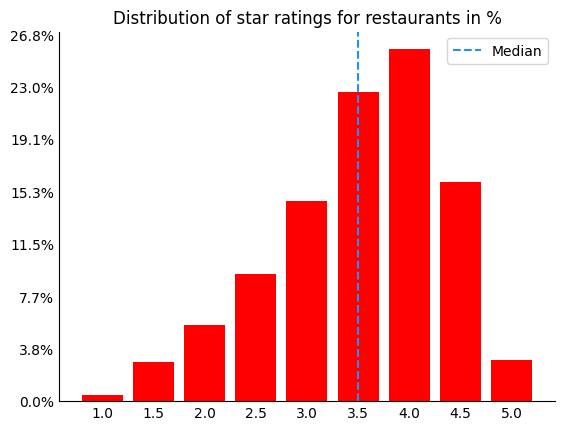

In [863]:
from matplotlib.ticker import PercentFormatter

x = restaurants[['business_id', 'stars']].groupby(by='stars').count().index
y = np.reshape(restaurants[['business_id', 'stars']].groupby(by='stars').count().values, (-1))

plt.bar(x, y, color='r', width=0.4)
plt.axvline(restaurants['stars'].median(), color='dodgerblue', linestyle='--', label='Median')
plt.title('Distribution of star ratings for restaurants in %')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.gca().yaxis.set_major_formatter(PercentFormatter(restaurants['stars'].count()))
plt.xticks(np.linspace(1, 5, 9))
plt.gca().spines[['right', 'top']].set_visible(False)
plt.tick_params(axis='both', length=0.0)
plt.legend()
plt.show();

### Prediction of star ratings

I will try to predict the star ratings based on three different explanatory variables:

* a set of 17 different business attributes (e.g. parking availability, price range, wifi availability)

* the number of online customer reviews the business has received

* the number of days per week a business a is open per week

<br/>

But before we continue there is still some data cleaning to do.

In [866]:
attributes = restaurants[
    [
        'stars',
        'accepts_credit_cards',
        'bike_parking',
        'price_range',
        'take_out',
        'delivery',
        'caters',
        'wi_fi',
        'outdoor_seating',
        'has_tv',
        'reservations',
        'alcohol',
        'good_for_kids',
        'parking',
        'attire',
        'table_service',
        'good_for_groups',
        'noise_level'
    ]
].copy()

The output of the cell below shows the unique values for each attribute. Mostly, we need to take care of the different 'None' and 'none' strings. What we want to do:

* Change the 'None' values in the columns 'price_range' and 'noise_level' to NaN. They do not really tell us anything.
* Change the 'None' values in the other columns to 'False. Though the meaning is not 100% clear this seems reasonable for now, e.g. if 'table_service' is 'None' this could mean there is no table service (=False). Also, we would lose too many samples, by excluding these rows.

In [876]:
print('Unique values for each attribute: \n')
for col in attributes.iloc[:, 1:]:
    print(col.ljust(25, ' '), attributes[col].unique())

Unique values for each attribute: 

accepts_credit_cards      ['False' 'True' nan 'None']
bike_parking              ['True' 'False' nan 'None']
price_range               ['1' nan '2' '3' '4' 'None']
take_out                  ['True' nan 'None' 'False']
delivery                  ['False' 'True' nan 'None']
caters                    ['True' 'False' nan 'None']
wi_fi                     ['free' 'no' nan 'paid' 'None']
outdoor_seating           ['False' 'True' 'None' nan]
has_tv                    [nan 'True' 'False' 'None']
reservations              [nan 'False' 'True' 'None']
alcohol                   ['none' 'full_bar' 'beer_and_wine' nan 'None']
good_for_kids             [nan 'True' 'False' 'None']
parking                   ['True' nan 'False']
attire                    [nan 'casual' 'formal' 'dressy' 'None']
table_service             [nan 'False' 'True' 'None']
good_for_groups           [nan 'True' 'False' 'None']
noise_level               [nan 'average' 'quiet' 'loud' 'very_loud' 'No

In [679]:
attributes = attributes.replace(['none', 'None'], ['False', 'False'])

In [680]:
# We also need to drop rows that contain one or more NaN values. In return we receive a dataset without any missing values.

attributes.dropna(inplace=True)

In [681]:
attributes

,stars,accepts_credit_cards,bike_parking,price_range,take_out,delivery,caters,wi_fi,outdoor_seating,has_tv,reservations,alcohol,good_for_kids,parking,attire,table_service,good_for_groups,noise_level
6,4.5,True,True,1,True,True,True,no,False,True,False,False,True,True,casual,False,False,average
8,4.5,True,True,1,True,False,True,no,False,True,False,False,True,True,casual,True,False,quiet
11,2.5,True,True,2,True,True,True,free,True,True,True,full_bar,True,True,casual,True,True,average
14,4.0,True,True,2,True,True,False,free,False,True,False,full_bar,False,True,casual,True,True,average
16,3.0,True,True,1,True,True,False,no,True,True,False,False,True,False,casual,True,True,average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52240,4.0,True,True,2,True,True,False,no,False,True,True,False,True,True,casual,True,True,quiet
52247,3.5,True,True,2,False,False,False,no,True,True,False,full_bar,False,True,casual,True,True,average
52248,3.0,True,False,3,True,True,True,free,False,True,True,full_bar,True,True,casual,True,True,very_loud
52253,4.0,True,True,2,True,True,False,free,True,True,False,beer_and_wine,True,True,casual,False,True,average


We can now take a look at the relative frequencies for all of our attributes.

In [682]:
# Relative frequencies

for label in attributes.iloc[:, 1:]:
    display(attributes[label].value_counts(normalize=True, sort=False))

accepts_credit_cards
True     0.978128
False    0.021872
Name: proportion, dtype: float64

bike_parking
True     0.778597
False    0.221403
Name: proportion, dtype: float64

price_range
1    0.304785
2    0.652476
3    0.039303
4    0.003436
Name: proportion, dtype: float64

take_out
True     0.949971
False    0.050029
Name: proportion, dtype: float64

delivery
True     0.597251
False    0.402749
Name: proportion, dtype: float64

caters
True     0.627085
False    0.372915
Name: proportion, dtype: float64

wi_fi
no       0.404006
free     0.590799
paid     0.004860
False    0.000335
Name: proportion, dtype: float64

outdoor_seating
False    0.452862
True     0.547138
Name: proportion, dtype: float64

has_tv
True     0.745244
False    0.254756
Name: proportion, dtype: float64

reservations
False    0.596581
True     0.403419
Name: proportion, dtype: float64

alcohol
False            0.418084
full_bar         0.405011
beer_and_wine    0.176904
Name: proportion, dtype: float64

good_for_kids
True     0.860052
False    0.139948
Name: proportion, dtype: float64

parking
True     0.881086
False    0.118914
Name: proportion, dtype: float64

attire
casual    0.977876
dressy    0.020867
formal    0.000754
False     0.000503
Name: proportion, dtype: float64

table_service
False    0.322048
True     0.677952
Name: proportion, dtype: float64

good_for_groups
False    0.090673
True     0.909327
Name: proportion, dtype: float64

noise_level
average      0.775245
quiet        0.150675
loud         0.059583
very_loud    0.014498
Name: proportion, dtype: float64

In [683]:
for label in attributes.iloc[:, 1:]:
    display(pd.crosstab(attributes['stars'], attributes[label], margins=True))


accepts_credit_cards,False,True,All
stars,,,
1.0,0,8,8
1.5,0,82,82
2.0,2,260,262
2.5,4,643,647
3.0,17,1358,1375
3.5,43,2862,2905
4.0,118,4145,4263
4.5,70,2181,2251
5.0,7,133,140


bike_parking,False,True,All
stars,,,
1.0,3,5,8
1.5,26,56,82
2.0,105,157,262
2.5,204,443,647
3.0,363,1012,1375
3.5,654,2251,2905
4.0,823,3440,4263
4.5,434,1817,2251
5.0,30,110,140


price_range,1,2,3,4,All
stars,,,,,
1.0,6,1,1,0,8
1.5,61,19,1,1,82
2.0,141,120,1,0,262
2.5,219,422,5,1,647
3.0,398,954,21,2,1375
3.5,790,1994,117,4,2905
4.0,1110,2925,216,12,4263
4.5,822,1303,105,21,2251
5.0,90,48,2,0,140


take_out,False,True,All
stars,,,
1.0,2,6,8
1.5,5,77,82
2.0,8,254,262
2.5,22,625,647
3.0,36,1339,1375
3.5,102,2803,2905
4.0,260,4003,4263
4.5,152,2099,2251
5.0,10,130,140


delivery,False,True,All
stars,,,
1.0,2,6,8
1.5,15,67,82
2.0,60,202,262
2.5,191,456,647
3.0,506,869,1375
3.5,1158,1747,2905
4.0,1768,2495,4263
4.5,1031,1220,2251
5.0,75,65,140


caters,False,True,All
stars,,,
1.0,5,3,8
1.5,70,12,82
2.0,182,80,262
2.5,338,309,647
3.0,499,876,1375
3.5,1019,1886,2905
4.0,1579,2684,4263
4.5,730,1521,2251
5.0,28,112,140


wi_fi,False,free,no,paid,All
stars,,,,,
1.0,0,4,3,1,8
1.5,0,47,34,1,82
2.0,0,137,122,3,262
2.5,1,371,270,5,647
3.0,0,823,542,10,1375
3.5,2,1749,1144,10,2905
4.0,1,2534,1709,19,4263
4.5,0,1313,931,7,2251
5.0,0,72,66,2,140


outdoor_seating,False,True,All
stars,,,
1.0,6,2,8
1.5,53,29,82
2.0,153,109,262
2.5,352,295,647
3.0,636,739,1375
3.5,1227,1678,2905
4.0,1879,2384,4263
4.5,1027,1224,2251
5.0,71,69,140


has_tv,False,True,All
stars,,,
1.0,3,5,8
1.5,8,74,82
2.0,26,236,262
2.5,85,562,647
3.0,198,1177,1375
3.5,541,2364,2905
4.0,1174,3089,4263
4.5,926,1325,2251
5.0,79,61,140


reservations,False,True,All
stars,,,
1.0,7,1,8
1.5,76,6,82
2.0,230,32,262
2.5,494,153,647
3.0,829,546,1375
3.5,1615,1290,2905
4.0,2301,1962,4263
4.5,1457,794,2251
5.0,110,30,140


alcohol,False,beer_and_wine,full_bar,All
stars,,,,
1.0,7,0,1,8
1.5,71,0,11,82
2.0,175,10,77,262
2.5,307,41,299,647
3.0,532,151,692,1375
3.5,1010,423,1472,2905
4.0,1601,917,1745,4263
4.5,1170,548,533,2251
5.0,116,21,3,140


good_for_kids,False,True,All
stars,,,
1.0,3,5,8
1.5,10,72,82
2.0,14,248,262
2.5,49,598,647
3.0,136,1239,1375
3.5,406,2499,2905
4.0,737,3526,4263
4.5,307,1944,2251
5.0,8,132,140


parking,False,True,All
stars,,,
1.0,6,2,8
1.5,37,45,82
2.0,106,156,262
2.5,140,507,647
3.0,223,1152,1375
3.5,298,2607,2905
4.0,368,3895,4263
4.5,212,2039,2251
5.0,29,111,140


attire,False,casual,dressy,formal,All
stars,,,,,
1.0,0,8,0,0,8
1.5,0,81,1,0,82
2.0,0,260,1,1,262
2.5,0,642,4,1,647
3.0,0,1364,11,0,1375
3.5,0,2850,52,3,2905
4.0,6,4135,118,4,4263
4.5,0,2189,62,0,2251
5.0,0,140,0,0,140


table_service,False,True,All
stars,,,
1.0,8,0,8
1.5,62,20,82
2.0,157,105,262
2.5,280,367,647
3.0,390,985,1375
3.5,759,2146,2905
4.0,1166,3097,4263
4.5,934,1317,2251
5.0,87,53,140


good_for_groups,False,True,All
stars,,,
1.0,5,3,8
1.5,20,62,82
2.0,30,232,262
2.5,55,592,647
3.0,96,1279,1375
3.5,166,2739,2905
4.0,357,3906,4263
4.5,322,1929,2251
5.0,31,109,140


noise_level,average,loud,quiet,very_loud,All
stars,,,,,
1.0,4,3,1,0,8
1.5,54,15,8,5,82
2.0,184,27,28,23,262
2.5,446,87,84,30,647
3.0,1051,123,160,41,1375
3.5,2304,200,364,37,2905
4.0,3457,174,606,26,4263
4.5,1673,79,488,11,2251
5.0,78,3,59,0,140


In [684]:
# Ordinal classification
# Multiple ordinal regression

In [685]:
star_cat = pd.CategoricalDtype(categories=np.linspace(1, 5, 9), ordered=True)
attributes['stars'] = attributes['stars'].astype(star_cat)

In [686]:
from sklearn.preprocessing import OrdinalEncoder

In [687]:

cols_bool = [
       'accepts_credit_cards',
       'bike_parking',
       'price_range',
       'take_out',
       'delivery',
       'caters',
       'wi_fi',
       'outdoor_seating',
       'has_tv',
       'reservations',
       'alcohol',
       'good_for_kids',
       'parking',
       'attire',
       'table_service',
       'good_for_groups',
       'noise_level'
]

for col in cols_bool:
       enc = OrdinalEncoder()
       enc.fit(np.reshape(attributes[col], (-1, 1)))
       attributes[col] = enc.transform(np.reshape(attributes[col], (-1, 1)))

In [688]:
import numpy as np
from sklearn.model_selection import train_test_split

In [689]:
train, test = train_test_split(attributes, test_size=0.2, shuffle=True)

In [690]:
from statsmodels.miscmodels.ordinal_model import OrderedModel
# https://www.youtube.com/watch?v=pQWQSCSrBk4
# https://stats.oarc.ucla.edu/stata/dae/ordered-logistic-regression/
# Multinomial model?

In [691]:
# Create x and y values

mod_log = OrderedModel(train.iloc[:, 0], train.iloc[:, 1:], distr='logit')
res_log = mod_log.fit(method='bfgs', disp=True)
res_log.summary()

# p value (wald's test): variable is significantly associated with target variable

Optimization terminated successfully.
         Current function value: 1.549218
         Iterations: 102
         Function evaluations: 103
         Gradient evaluations: 103


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  stars   Log-Likelihood:                -14789.
Model:                   OrderedModel   AIC:                         2.963e+04
Method:            Maximum Likelihood   BIC:                         2.981e+04
Date:                Tue, 30 Jan 2024                                         
Time:                        15:47:53                                         
No. Observations:                9546                                         
Df Residuals:                    9521                                         
Df Model:                          17                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
accepts_credit_cards    -0.5496      0.126     -4.366      0.000      -0.796      -0.303
bike_parking             0.3586      0.046      7.737      0.000       0.268       0.449
price_range              0.0622      0.046      1.361      0.173      -0.027       0.152
take_out                -0.3674      0.089     -4.152      0.000      -0.541      -0.194
delivery                -0.4047      0.040    -10.161      0.000      -0.483      -0.327
caters                   0.4126      0.041     10.076      0.000       0.332       0.493
wi_fi                   -0.0599      0.039     -1.540      0.124      -0.136       0.016
outdoor_seating          0.0442      0.040      1.098      0.272      -0.035       0.123
has_tv                  -0.7471      0.047    -16.054      0.000      -0.838      -0.656
reservations             0.1477      0.045      3.277      0.001       0.059       0.236
alcohol                 -0.2893      0.028    -10.347      0.000      -0.344      -0.235
good_for_kids           -0.2244      0.059     -3.805      0.000      -0.340      -0.109
parking                  0.7492      0.062     11.999      0.000       0.627       0.872
attire                   0.1176      0.126      0.936      0.349      -0.129       0.364
table_service            0.1182      0.052      2.292      0.022       0.017       0.219
good_for_groups         -0.3734      0.071     -5.225      0.000      -0.513      -0.233
noise_level             -0.0260      0.025     -1.053      0.292      -0.074       0.022
1.0/1.5                 -8.6359      0.471    -18.317      0.000      -9.560      -7.712
1.5/2.0                  0.9413      0.153      6.159      0.000       0.642       1.241
2.0/2.5                  0.2936      0.074      3.990      0.000       0.149       0.438
2.5/3.0                  0.1003      0.045      2.221      0.026       0.012       0.189
3.0/3.5                  0.0724      0.029      2.495      0.013       0.016       0.129
3.5/4.0                  0.2233      0.019     11.773      0.000       0.186       0.260
4.0/4.5                  0.5563      0.015     36.074      0.000       0.526       0.587
4.5/5.0                  1.1520      0.030     38.088      0.000       1.093       1.211
========================================================================================
"""

In [692]:
# Is the assumption of proportional odds reasonable?

In [693]:
np.set_printoptions(suppress=True)
res_log.predict([1 for i in range(17)], which='prob')

array([[0.00049806, 0.00592769, 0.01770582, 0.04537673, 0.11007113,
        0.25356405, 0.38070865, 0.17658043, 0.00956744]])

In [694]:
pred_choice = res_log.predict(exog=test.iloc[:, 1:]).values.argmax(1)
print('Fraction of correct choice predictions')
print((np.asarray(test.iloc[:, 0].values.codes) == pred_choice).mean())


Fraction of correct choice predictions
0.35064935064935066


### Review counts

In [695]:
reviews = restaurants[['stars', 'review_count']].copy()

In [696]:
reviews.describe()

,stars,review_count
count,52268.000000,52268.000000
mean,3.515172,87.267142
std,0.829593,188.939711
min,1.000000,5.000000
25%,3.000000,13.000000
50%,3.500000,33.000000
75%,4.000000,89.000000
max,5.000000,7568.000000


In [697]:
reviews.groupby(by='stars').describe()

review_count                                                         
             count        mean         std  min   25%   50%     75%     max
stars                                                                      
1.0          247.0   14.101215   15.495406  5.0   6.0  10.0   16.00   176.0
1.5         1481.0   23.569210   23.414727  5.0  10.0  17.0   29.00   412.0
2.0         2909.0   27.309041   32.767013  5.0  10.0  17.0   31.00   357.0
2.5         4850.0   39.945155   79.424104  5.0  11.0  20.0   45.00  3401.0
3.0         7639.0   55.614347   98.090160  5.0  12.0  27.0   64.00  4250.0
3.5        11794.0   86.479481  146.754159  5.0  16.0  41.0   98.00  5185.0
4.0        13438.0  131.921938  255.195507  5.0  20.0  55.0  148.75  7568.0
4.5         8357.0  117.400981  255.865189  5.0  16.0  45.0  119.00  6093.0
5.0         1553.0   32.871861   64.064267  5.0   7.0  13.0   30.00   991.0

In [698]:
star_cat = pd.CategoricalDtype(categories=np.linspace(1, 5, 9), ordered=True)
reviews['stars'] = reviews['stars'].astype(star_cat)

In [699]:
X, y = reviews['review_count'], reviews['stars']

In [700]:
mod_log = OrderedModel(y, X, distr='logit')
res_log = mod_log.fit(method='bfgs', disp=True)
res_log.summary()

Optimization terminated successfully.
         Current function value: 1.859309
         Iterations: 34
         Function evaluations: 39
         Gradient evaluations: 39


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  stars   Log-Likelihood:                -97182.
Model:                   OrderedModel   AIC:                         1.944e+05
Method:            Maximum Likelihood   BIC:                         1.945e+05
Date:                Tue, 30 Jan 2024                                         
Time:                        15:48:00                                         
No. Observations:               52268                                         
Df Residuals:                   52259                                         
Df Model:                           1                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
review_count     0.0016   4.82e-05     32.373      0.000       0.001       0.002
1.0/1.5         -5.2432      0.064    -82.104      0.000      -5.368      -5.118
1.5/2.0          0.6813      0.030     22.741      0.000       0.623       0.740
2.0/2.5          0.0496      0.019      2.633      0.008       0.013       0.086
2.5/3.0         -0.1854      0.014    -13.214      0.000      -0.213      -0.158
3.0/3.5         -0.2235      0.011    -20.652      0.000      -0.245      -0.202
3.5/4.0         -0.0482      0.008     -5.737      0.000      -0.065      -0.032
4.0/4.5          0.2317      0.008     29.215      0.000       0.216       0.247
4.5/5.0          0.7162      0.012     60.453      0.000       0.693       0.739
================================================================================
"""

In [701]:
pred_choice = res_log.predict(X.values).argmax(1)
print('Fraction of correct choice predictions')
print((np.asarray(reviews['stars'].values.codes) == pred_choice).mean())

Fraction of correct choice predictions
0.25447692660901505


### What are the average opening hours of a restaurant? How many days is it open per week?

In [702]:
cols = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
opening_hours = restaurants[['stars'] + cols].copy()
opening_hours[cols] = restaurants[cols].apply(lambda x: x.str.split('-'))

In [703]:
def padding_time(x):
    if x is not np.nan:
        return [x[0] + ':00', x[1] + ':00']
    else:
        return np.nan

In [704]:
opening_hours[cols] = opening_hours[cols].map(padding_time)

In [705]:
def convert_time(x):
    if x is not np.nan:
        return [pd.to_timedelta(x[0]), pd.to_timedelta(x[1])]
    else:
        return pd.to_timedelta('nat')

In [706]:
opening_hours[cols] = opening_hours[cols].map(convert_time)

In [707]:
def get_hours(x):
    if x is pd.NaT:
        return pd.to_timedelta('nat')
    elif x[1] > x[0]:
        return x[1] - x[0]
    else:
        return x[1] - x[0] + pd.to_timedelta('24:00:00')

In [708]:
opening_hours[cols] = opening_hours[cols].map(get_hours)

In [709]:
opening_hours['days_open'] = opening_hours[cols].count(axis=1)
opening_hours['daily_avg_hours'] = opening_hours[cols].sum(axis=1) / opening_hours['days_open']
opening_hours.drop(columns=cols, inplace=True)

In [710]:
opening_hours.dropna(subset='daily_avg_hours', inplace=True)

In [711]:
star_cat = pd.CategoricalDtype(categories=np.linspace(1, 5, 9), ordered=True)
opening_hours['stars'] = opening_hours['stars'].astype(star_cat)

In [712]:
X, y = opening_hours['days_open'], opening_hours['stars']

In [713]:
mod_log = OrderedModel(y, X, distr='logit')
res_log = mod_log.fit(method='bfgs', disp=True)
res_log.summary()

Optimization terminated successfully.
         Current function value: 1.809193
         Iterations: 43
         Function evaluations: 47
         Gradient evaluations: 47


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  stars   Log-Likelihood:                -81396.
Model:                   OrderedModel   AIC:                         1.628e+05
Method:            Maximum Likelihood   BIC:                         1.629e+05
Date:                Tue, 30 Jan 2024                                         
Time:                        15:48:17                                         
No. Observations:               44990                                         
Df Residuals:                   44981                                         
Df Model:                           1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
days_open     -0.6773      0.011    -61.466      0.000      -0.699      -0.656
1.0/1.5       -9.9629      0.103    -96.962      0.000     -10.164      -9.761
1.5/2.0        0.7069      0.033     21.750      0.000       0.643       0.771
2.0/2.5        0.0208      0.021      0.998      0.318      -0.020       0.062
2.5/3.0       -0.2132      0.016    -13.533      0.000      -0.244      -0.182
3.0/3.5       -0.2211      0.012    -18.408      0.000      -0.245      -0.198
3.5/4.0       -0.0052      0.009     -0.569      0.569      -0.023       0.013
4.0/4.5        0.3036      0.008     36.331      0.000       0.287       0.320
4.5/5.0        0.7958      0.012     64.537      0.000       0.772       0.820
==============================================================================
"""

In [714]:
pred_choice = res_log.predict(X.values).argmax(1)
print('Fraction of correct choice predictions')
print((np.asarray(opening_hours['stars'].values.codes) == pred_choice).mean())

Fraction of correct choice predictions
0.2682596132473883
